In [44]:
#importing utility functions
import pandas as pd
import numpy as np
import os
import sys

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist



#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# importing custom functions
# %load_ext autoreload
# %autoreload 2

module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import nb_module

In [31]:
df = pd.read_csv("./data/reddit_vm.csv")

In [32]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [33]:
df.tail()

,title,score,id,url,comms_num,created,body,timestamp
1419,Comment,1,ejackaa,NaN,0,1.553486e+09,I didn't say thimerosal is mercury. I said thi...,2019-03-25 05:50:41
1420,Comment,2,ejacj98,NaN,0,1.553486e+09,"The ""myth"" you're debunking is in regards to t...",2019-03-25 05:50:20
1421,Comment,2,ejabpdx,NaN,0,1.553485e+09,You'll have to read it again because I didn't ...,2019-03-25 05:40:03
1422,Comment,0,ej9xuaf,NaN,0,1.553475e+09,"What do you mean by ""your OP"". I am fairly new...",2019-03-25 02:45:21
1423,Comment,1,ej9x2qr,NaN,0,1.553474e+09,"When they say there's no thimerasol, they mean...",2019-03-25 02:35:47


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1424 non-null   object 
 1   score      1424 non-null   int64  
 2   id         1424 non-null   object 
 3   url        444 non-null    object 
 4   comms_num  1424 non-null   int64  
 5   created    1424 non-null   float64
 6   body       1059 non-null   object 
 7   timestamp  1424 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 89.1+ KB


In [35]:
df.isna().sum()

title          0
score          0
id             0
url          980
comms_num      0
created        0
body         365
timestamp      0
dtype: int64

In [36]:
df.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')

In [37]:
columns_to_drop = ['score', 'id', 'url', 'comms_num', 'created']
df.drop(labels = columns_to_drop, axis = 1, inplace=True)

## Data Cleaning Title

Removing any grammatical symbols from the text and converting everything to lower case 

In [38]:
df['cleaned_title'] = df['title'].apply(lambda x: nb_module.clean_data(x))
df.head()

,title,body,timestamp,cleaned_title
0,Health Canada approves AstraZeneca COVID-19 va...,NaN,2021-02-27 06:33:45,health canada approves astrazeneca covid vaccine
1,COVID-19 in Canada: 'Vaccination passports' a ...,NaN,2021-02-26 07:11:07,covid in canada vaccination passports a near c...
2,Coronavirus variants could fuel Canada's third...,NaN,2021-02-21 07:50:08,coronavirus variants could fuel canadas third ...
3,Canadian government to extend COVID-19 emergen...,NaN,2021-02-20 06:35:13,canadian government to extend covid emergency ...
4,Canada: Pfizer is 'extremely committed' to mee...,NaN,2021-02-16 11:36:28,canada pfizer is extremely committed to meetin...


In [10]:
len(df)

1424

In [39]:
df_cleaned_title = df[df['title'] != 'Comment']
len(df_cleaned_title)

444

In [40]:
df_cleaned_title.tail()

,title,body,timestamp,cleaned_title
440,I am a father of five unvaccinated children. A...,NaN,2014-01-13 16:55:48,i am a father of five unvaccinated children am...
441,Love Them. Protect Them. Never Inject Them.,NaN,2014-01-13 16:53:07,love them protect them never inject them
442,Vaccines Are Just Asping For Trouble,NaN,2014-01-13 16:47:31,vaccines are just asping for trouble
443,Dr. Harper explained in her presentation that ...,NaN,2014-01-13 16:44:57,dr harper explained in her presentation that t...
444,Polio arose in the US at a period where pestic...,NaN,2014-01-13 16:42:55,polio arose in the us at a period where pestic...


### Tokenize Title

In [42]:
df_cleaned_title['tokenized'] = df_cleaned_title['cleaned_title'].apply(lambda x: nb_module.tokenize(x))

In [43]:
df_cleaned_title.head()

,title,body,timestamp,cleaned_title,tokenized
0,Health Canada approves AstraZeneca COVID-19 va...,NaN,2021-02-27 06:33:45,health canada approves astrazeneca covid vaccine,"[health, canada, approves, astrazeneca, covid,..."
1,COVID-19 in Canada: 'Vaccination passports' a ...,NaN,2021-02-26 07:11:07,covid in canada vaccination passports a near c...,"[covid, canada, vaccination, passports, near, ..."
2,Coronavirus variants could fuel Canada's third...,NaN,2021-02-21 07:50:08,coronavirus variants could fuel canadas third ...,"[coronavirus, variants, could, fuel, canadas, ..."
3,Canadian government to extend COVID-19 emergen...,NaN,2021-02-20 06:35:13,canadian government to extend covid emergency ...,"[canadian, government, extend, covid, emergenc..."
4,Canada: Pfizer is 'extremely committed' to mee...,NaN,2021-02-16 11:36:28,canada pfizer is extremely committed to meetin...,"[canada, pfizer, extremely, committed, meeting..."


### Stemming Title
-- **with Porter Stemmer**

In [50]:
df_cleaned_title['stemmed'] = df_cleaned_title['tokenized'].apply(lambda x: nb_module.stemming(x))

In [51]:
df_cleaned_title.head()

,title,body,timestamp,cleaned_title,tokenized,stemmed
0,Health Canada approves AstraZeneca COVID-19 va...,NaN,2021-02-27 06:33:45,health canada approves astrazeneca covid vaccine,"[health, canada, approves, astrazeneca, covid,...",health canada approv astrazeneca covid vaccin
1,COVID-19 in Canada: 'Vaccination passports' a ...,NaN,2021-02-26 07:11:07,covid in canada vaccination passports a near c...,"[covid, canada, vaccination, passports, near, ...",covid canada vaccin passport near certainti sa...
2,Coronavirus variants could fuel Canada's third...,NaN,2021-02-21 07:50:08,coronavirus variants could fuel canadas third ...,"[coronavirus, variants, could, fuel, canadas, ...",coronaviru variant could fuel canada third wave
3,Canadian government to extend COVID-19 emergen...,NaN,2021-02-20 06:35:13,canadian government to extend covid emergency ...,"[canadian, government, extend, covid, emergenc...",canadian govern extend covid emerg benefit
4,Canada: Pfizer is 'extremely committed' to mee...,NaN,2021-02-16 11:36:28,canada pfizer is extremely committed to meetin...,"[canada, pfizer, extremely, committed, meeting...",canada pfizer extrem commit meet vaccin delive...


In [52]:
df_cleaned_title.tail()

,title,body,timestamp,cleaned_title,tokenized,stemmed
440,I am a father of five unvaccinated children. A...,NaN,2014-01-13 16:55:48,i am a father of five unvaccinated children am...,"[father, five, unvaccinated, children, unfit, ...",father five unvaccin children unfit parent opi...
441,Love Them. Protect Them. Never Inject Them.,NaN,2014-01-13 16:53:07,love them protect them never inject them,"[love, protect, never, inject]",love protect never inject
442,Vaccines Are Just Asping For Trouble,NaN,2014-01-13 16:47:31,vaccines are just asping for trouble,"[vaccines, asping, trouble]",vaccin asp troubl
443,Dr. Harper explained in her presentation that ...,NaN,2014-01-13 16:44:57,dr harper explained in her presentation that t...,"[dr, harper, explained, presentation, cervical...",dr harper explain present cervic cancer risk u...
444,Polio arose in the US at a period where pestic...,NaN,2014-01-13 16:42:55,polio arose in the us at a period where pestic...,"[polio, arose, us, period, pesticide, use, sky...",polio aros us period pesticid use skyrocket ap...


### Pickling df_cleaned_title

In [55]:
df_cleaned_title.to_pickle("./pickle/cleaned_title.pkl")

## Data Cleaning Body

## EDA


In [27]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('bmh')
# from matplotlib import cm
# import seaborn as sns

# #NLP libraries
# import nltk
# from sklearn.feature_extraction import text
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from nltk.probability import FreqDist
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [28]:
# nltk.download('vader_lexicon')

In [29]:
sid = SentimentIntensityAnalyzer()

In [30]:
for title in df_cleaned['cleaned_title']:
    print(title)
    ss = sid.polarity_scores(title)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
        print()

health canada approves astrazeneca covid vaccine
compound: 0.4019, 
neg: 0.0, 
neu: 0.649, 
pos: 0.351, 
covid in canada vaccination passports a near certainty says bioethicist
compound: 0.25, 
neg: 0.0, 
neu: 0.8, 
pos: 0.2, 
coronavirus variants could fuel canadas third wave
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
canadian government to extend covid emergency benefits
compound: 0.1779, 
neg: 0.239, 
neu: 0.367, 
pos: 0.394, 
canada pfizer is extremely committed to meeting vaccine delivery targets
compound: 0.3384, 
neg: 0.0, 
neu: 0.79, 
pos: 0.21, 
canada oxfordastrazeneca vaccine approval expected this week
compound: 0.4767, 
neg: 0.0, 
neu: 0.659, 
pos: 0.341, 
covid músicos que han recibido la vacuna
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
now casting covid vaccine volunteers freezer truck drivers and others
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
beer after corona vaccination
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
waiting for vaccine
compound

compound: -0.2732, 
neg: 0.078, 
neu: 0.869, 
pos: 0.053, 
this powerpoint is my attempt at a public resource for exhaustively addressing antivax claims this will remain a work in progress to be updated to follow emerging popular claims suggestions are encouraged please read and share
compound: 0.872, 
neg: 0.04, 
neu: 0.662, 
pos: 0.298, 
im interested in discussing the vaccine aspect of this documentary and the arguments presented within note its only available for the next six days for free
compound: 0.5106, 
neg: 0.085, 
neu: 0.726, 
pos: 0.189, 
antivax mom makes concentration campstyle badge to protest her persecution
compound: -0.25, 
neg: 0.182, 
neu: 0.818, 
pos: 0.0, 
lifting the lid on the vaccination debate why we deserve to hear both sides of the argument
compound: -0.3612, 
neg: 0.135, 
neu: 0.865, 
pos: 0.0, 
basically just a bunch of bullshit talking points dreamed up by vaccine propagandists to scare you into using their products and push the public debate toward manda

pos: 0.0, 
no real quote from this guy you just have to read what hes writing hes completely bungling immunology
compound: -0.296, 
neg: 0.115, 
neu: 0.885, 
pos: 0.0, 
this will enrich big pharma and allow the government to put whatever chemical into the publics bloodstream they the government sees fit this is putting too much trust in the government
compound: 0.7717, 
neg: 0.0, 
neu: 0.784, 
pos: 0.216, 
this is a pretty terribly written blog
compound: -0.1027, 
neg: 0.333, 
neu: 0.37, 
pos: 0.296, 
those in favor of vaccines are fighting a loosing battle its stupid to vaccinate a  minute old infant against a sexually transmitted disease
compound: -0.7003, 
neg: 0.312, 
neu: 0.588, 
pos: 0.099, 
i stopped reading at the second sentence first paragraph when you asked me to prove to you that diet and exercise are healthy and boost the immune system such elementary ignorance warrants no further interest
compound: 0.6486, 
neg: 0.148, 
neu: 0.584, 
pos: 0.267, 
the toll of the antivaccin

In [31]:
def find_sentiment(text):
    polarity_score = sid.polarity_scores(text)['compound']
    
    if polarity_score < 0:
        sentiment = "negative"
    elif polarity_score > 0:
        sentiment = "positive"
    elif polarity_score == 0:
        sentiment = 'neutral'
    return sentiment

In [32]:
# df_cleaned.loc[:,'sentiment'] = df_cleaned['cleaned_title'].apply(lambda x: find_sentiment(x))
# df_cleaned.loc[:,'compound_score'] = df_cleaned['cleaned_title'].apply(lambda x: sid.polarity_scores(x)['compound'])

df_cleaned['sentiment'] = df_cleaned['cleaned_title'].apply(lambda x: find_sentiment(x))

df_cleaned['compound_score'] = df_cleaned['cleaned_title'].apply(lambda x: sid.polarity_scores(x)['compound'])



In [41]:
df_cleaned.tail()

,title,score,id,url,comms_num,created,body,timestamp,cleaned_title,sentiment,compound_score
440,I am a father of five unvaccinated children. A...,1,1v3c8o,http://www.np.reddit.com/r/conspiracy/comments...,1,1.389625e+09,NaN,2014-01-13 16:55:48,i am a father of five unvaccinated children am...,neutral,0.0000
441,Love Them. Protect Them. Never Inject Them.,1,1v3c3i,http://i.imgur.com/SkB0a6T.jpg,2,1.389625e+09,NaN,2014-01-13 16:53:07,love them protect them never inject them,positive,0.7783
442,Vaccines Are Just Asping For Trouble,2,1v3brt,http://i.imgur.com/bIPQpbv.jpg,1,1.389624e+09,NaN,2014-01-13 16:47:31,vaccines are just asping for trouble,negative,-0.4019
443,Dr. Harper explained in her presentation that ...,1,1v3blj,http://www.feelguide.com/2013/07/16/lead-devel...,1,1.389624e+09,NaN,2014-01-13 16:44:57,dr harper explained in her presentation that t...,negative,-0.8883
444,Polio arose in the US at a period where pestic...,1,1v3bh2,http://www.np.reddit.com/r/medicine/comments/1...,1,1.389624e+09,NaN,2014-01-13 16:42:55,polio arose in the us at a period where pestic...,negative,-0.6808


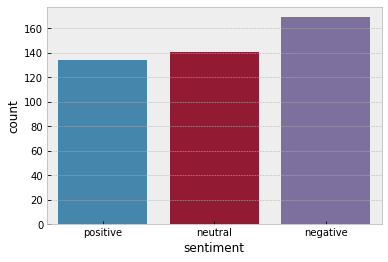

In [35]:
sns.countplot(df_cleaned['sentiment']);

In [36]:
from datetime import datetime

In [39]:
time_series_df = df_cleaned.copy()
time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp'])
time_series_df['date'] = [d.date() for d in time_series_df['timestamp']]
time_series_df.set_index(['date', 'sentiment'], inplace=True)

In [42]:
time_series_df.head()

,,title,score,id,url,comms_num,created,body,timestamp,cleaned_title,compound_score
date,sentiment,,,,,,,,,,
2021-02-27,positive,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45,health canada approves astrazeneca covid vaccine,0.4019
2021-02-26,positive,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07,covid in canada vaccination passports a near c...,0.2500
2021-02-21,neutral,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08,coronavirus variants could fuel canadas third ...,0.0000
2021-02-20,positive,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13,canadian government to extend covid emergency ...,0.1779
2021-02-16,positive,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28,canada pfizer is extremely committed to meetin...,0.3384


In [104]:
sentiment_volume = pd.DataFrame(time_series_df.groupby(['date', 'sentiment']).size(), columns = ['sentiment_count'])

In [105]:
sentiment_volume.head(2)

sentiment_count
date       sentiment                 
2014-01-13 negative                 9
           neutral                  1

In [107]:
# sentiment_volume['date'] = pd.to_datetime(sentiment_volume['date'], format = '%Y-%m-%d')

In [98]:
sentiment_volume.set_index('date', inplace=True)

In [99]:
sentiment_volume.head(2)

,sentiment,sentiment_count
date,,
2014-01-13,negative,9
2014-01-13,neutral,1


In [140]:
sentiment_vol_1 = sentiment_volume['sentiment_count'].unstack().reset_index()

In [148]:
sentiment_vol_1.set_index('date', inplace=True)

In [151]:
sentiment_vol_1.head()

sentiment,negative,neutral,positive
date,,,
2014-01-13,9.0,1.0,3.0
2014-01-14,1.0,NaN,1.0
2014-01-15,2.0,1.0,NaN
2014-01-16,NaN,1.0,NaN
2014-01-17,15.0,1.0,9.0


In [158]:
sentiment_vol_1.fillna(0, inplace= True )

In [166]:
sentiment_vol_monthly = sentiment_vol_1.resample('MS').sum()

<AxesSubplot:xlabel='date'>

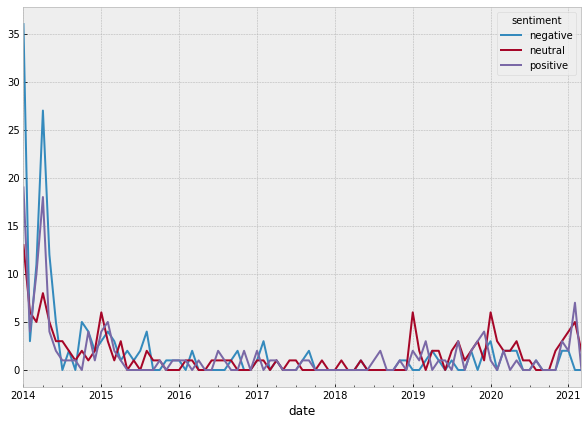

In [167]:
sentiment_vol_monthly.plot(figsize = (10, 7))

### Vectorization

Converting the text into a vector where each element in the vector represents a different word.
The vector is the length of the entire vocabulary -- here, every word that appears in our corpus.

In [15]:
# function to return a count vectorized representation of text as a dictionary
def count_vectorize(text, vocab=None):
# vocab is an optional parameter set to default to None
# vocab is just in case we use a vocabulary that contains words not seen in the song

    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(text))
    
    # empty dictionary with keys as the unique words in the corpus
    text_dict = {i:0 for i in unique_words}
    
    # adding count values for each unique words
    for t in text:
        text_dict[t] +=1
    
    return text_dict
    

In [17]:
vectorized_title = count_vectorize(tokenized_title)
print(vectorized_title)

{'advocating': 1, 'refutes': 1, 'er': 1, 'antivaxxing': 2, 'merck': 1, 'th': 1, 'present': 2, 'sids': 2, 'an': 26, 'woo': 2, 'evidence': 6, 'perfectly': 1, 'deem': 1, 'refuse': 2, 'course': 3, 'allow': 1, 'thinking': 2, 'reasoned': 1, 'she': 4, 'guilt': 1, 'damaging': 1, '12': 1, 'body': 6, 'acellular': 1, 'news': 3, 'pathetic': 1, 'slow': 1, 'while': 1, 'fraud': 1, '4': 2, '3': 2, 'consider': 1, 'recently': 1, 'back': 4, 'led': 1, 'spreads': 1, 'vote': 1, 'individuals': 2, 'honestly': 1, 'lid': 1, 'play': 1, 'better': 4, 'without': 1, 'those': 6, 'frantically': 1, '$': 1, 'kills': 2, 'fascist': 1, 'resource': 1, 'police': 2, 'vaxx': 1, 'question': 4, 'proof': 8, 'safe': 3, 'circulating': 1, 'aunt': 1, 'families': 3, 'ironically': 1, 'americans': 2, 'manufacturers': 1, 'oxfordastrazeneca': 1, 'always': 1, 'academic': 1, 'bothered': 1, 'hisher': 1, 'control': 3, 'turned': 1, 'feed': 1, '”': 3, 'alters': 1, 'deadly': 2, 'populace': 1, 'scientifically': 2, 'written': 1, 'ekg': 1, 'that': 

### TF-IDF Vectorization
TF-IDF is a more advanced form of vectorization that weighs each term in a document by how unique it is to the given document it is contained in. This allows us to summarize the contents of a document using a few KEY WORDS.

If the word is used often in many other documents, it is not unique and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents.

Conversely, if a word is used many times in a document, but rarely in all the other documents we are looking into, then it is likely a good indicator for telling us that this word is important to the document in question

In [ ]:
# Function to calculate the TF